### Import data to Pandas dataframes

In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### convert categorical data (strings) to numerical data, fill NaNs

In [2]:
def scale_features(X):
    ''' scale the features columnwise to 0 mean and normalize by range
    '''
    for i in range(len(X[1,:])):
        X[:,i] = (X[:,i] - X[:,i].mean())/(X[:,i].max()-X[:,i].min())
    return X

def fill_nan(X):
    '''replace NaNs with mean for each column
    ''' 
    for i in range(len(X[1,:])):
        mean = np.nanmean(X[:,i])
        mask = np.isnan(X[:,i])
        X[mask,i] = mean
    return X


def strings_to_num(df):
    '''Input: df (Pandas dataframe)
       Ouput: numpy array with categorical (string) columns transformed into numerical
    '''
    #transform dataframe categories to numbers
    return df.apply(lambda x: pd.factorize(x)[0]).values

def df_to_numpy_array(df):
    ''' Seperate categorical and numerical columns of dataframe
        Input df: Pandas dataframe
        Output: numpy array
    '''
    #get names of numerical columns
    num_columns = list(df.select_dtypes(include=['float64', 'int64']).columns.values)
    
    #get numerical values into NumPy array
    num_values = df[num_columns].values
    
    #fill NaN in numerical features
    num_values = fill_nan(num_values)
    
    #scale numerical features
    num_values = scale_features(num_values)   
    
    #get categorical columns 
    cat_columns = list(df.select_dtypes(include=['object']).columns.values)

    #transform categorical columns into numpy array
    cat_values = strings_to_num(df[cat_columns])
    
    return np.concatenate((cat_values,num_values),axis=1)


feature_names = train_df.drop(["SalePrice","Id"],axis=1).columns.tolist()
num_features = len(feature_names)    
    
X = df_to_numpy_array(train_df.drop(["SalePrice","Id"],axis=1))     #training data
Xtest = df_to_numpy_array(test_df.drop(["Id"],axis=1)) #test data
y = train_df['SalePrice'].values #target
test_ids = test_df["Id"].values

### try a simple linear model 

In [3]:
from sklearn import linear_model
from sklearn import cross_validation

lm = linear_model.LinearRegression()
lm = lm.fit(X,y)

scores = cross_validation.cross_val_score(lm, X, y, cv=4, n_jobs=-1)
print("scores = ",scores)
print("mean   = %4.2f" % (scores.mean()))

/home/dan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


scores =  [  8.45188936e-01   8.04865131e-01  -2.14621778e+23   5.63582627e-01]
mean   = -53655444413939615531008.00


In 4-fold cross-validation, the linear model is succesful 3 times but fails for one of the CV sets. There is likely an outlier or error in the data that is throwing off the fit. 

### try random forest

In [4]:
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit( X, y )

scores = cross_validation.cross_val_score(rf, X, y, cv=3, n_jobs=-1)
print("accuracies     = ",scores)
print("mean accuracy = %4.2f" % (scores.mean()))

accuracies     =  [ 0.89002369  0.84950746  0.81385324]
mean accuracy = 0.85


## Plotting accuracy vs n_estimators 
Due to the random generation of random forests, the plot changes somewhat each time it is run, but it confirms that 200 is a reasonable number (going higher won't help much) 

/home/dan/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/home/dan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


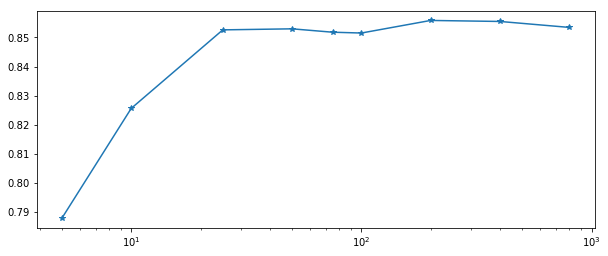

In [5]:
from sklearn.learning_curve import validation_curve

num_to_try = [5,10,25,50,75,100,200,400,800]
train_scores, valid_scores = validation_curve(RandomForestRegressor(), 
                                              X, y, 
                                              "n_estimators",
                                               num_to_try, n_jobs=-1)

f, ax = plt.subplots(figsize=(10,4))
ax.semilogx(num_to_try, np.mean(valid_scores, axis=1),"-*")
f.show()

### loook at feature importance from random forest

/home/dan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


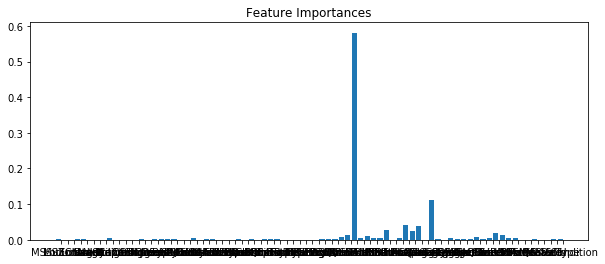

In [6]:
f, ax = plt.subplots(figsize=(10,4))

bar_placements = range(len(rf.feature_importances_))
ax.bar(bar_placements, rf.feature_importances_)
ax.set_title("Feature Importances")
ax.set_xticks([tick + .5 for tick in bar_placements])
ax.set_xticklabels(feature_names)

f.show()

A few features dominate. What are these? 

In [7]:
#create dictionary
f_imps = {}
for i in range(num_features):
    f_imps[feature_names[i]] = rf.feature_importances_[i]
    
#sort dictionary 
sorted_feature_names = sorted(f_imps, key=f_imps.__getitem__, reverse=True)
sorted_values = sorted(f_imps.values(), reverse=True)

num_to_print = 20
for i in range(num_to_print):
    print("%15s %4.3f" % (sorted_feature_names[i],sorted_values[i]))


   BsmtFullBath 0.581
    GarageYrBlt 0.112
     Functional 0.041
    FireplaceQu 0.038
   KitchenAbvGr 0.029
     Fireplaces 0.024
      3SsnPorch 0.020
    ScreenPorch 0.014
      GrLivArea 0.013
       FullBath 0.010
     WoodDeckSF 0.008
   LowQualFinSF 0.007
       HalfBath 0.006
   BedroomAbvGr 0.005
   TotRmsAbvGrd 0.005
  EnclosedPorch 0.005
   BsmtHalfBath 0.005
      Utilities 0.005
       PoolArea 0.004
         PoolQC 0.004


### Try smaller number of features 
let's try doing the regression with only the 20 most important features 

### Try neural network with Keras

this was copied from the example here : http://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/, but I removed the pipline and some other stuff to make it simplier, and changing error quantification ("objective") to mean_absolute_percentage_error so we can compute accuracies like above

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import cross_val_score

# define base mode
def model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=num_features, init='normal', activation='relu'))
    model.add(Dense(20, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='msle', optimizer='adam')
    return model

# evaluate model with standardized dataset
kr = KerasRegressor(build_fn=model, nb_epoch=100, batch_size=5, verbose=0)

scores = cross_val_score(kr, X, y, cv=4)
print("msle = %4.2f std = %4.2f" % (scores.mean(),scores.std()))


Using TensorFlow backend.
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(60, input_dim=79, activation="relu", kernel_initializer="normal")`
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`


msle = 7.89 std = 1.29


In [9]:
kr = KerasRegressor(build_fn=model, nb_epoch=500, batch_size=5, verbose=1)
kr = kr.fit(X,y)

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(60, input_dim=79, activation="relu", kernel_initializer="normal")`
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`


Epoch 1/10
1460/1460 [==============================] - 0s - loss: 79.6824       
Epoch 2/10
1460/1460 [==============================] - 0s - loss: 36.9113     

### Run prediction and save result to .csv

In [10]:
predictions = kr.model.predict(Xtest)

to_save = np.concatenate((np.reshape(test_ids,(len(test_ids),1)), predictions),axis=1)
np.savetxt("predictions.csv",to_save,header="Id,SalePrice",delimiter=',',comments="",fmt=["%8i", "%8.6f"],)